<a href="https://colab.research.google.com/github/Manoj250/action-detection-with-RNN/blob/main/Human_action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project the actions we are categorizing are two yoga poses namely 
half moon pose and camel pose ,as i could not find any temporal datasets(here by temporal i mean sequence of images which contitute a single action for example there are multiple steps for a single yoga pose)
i have created my own small dataset which you can find here [here](https://drive.google.com/file/d/1pZvLsqEZAhL4RX9UD7akBZRFplgQAnKj/view?usp=sharing) it contains 7 steps for each asana performed by multiple individuals.
Here we are using:- 

1.   **LSTM** : Vanishing gradient problem of RNN is solved and is able to remember long sequence of data.we are using this layer as we we have to deal with temporal data(images of steps at differnt times)
2.   **Conv2d** : Extract the features from the images
3.   **Maxpooling** :Reduce the dimension of the features generated by conv2d layers
4.   **TimeDistributed** : This layer is used as a wrapper around differnet layers(like conv2d,dense etc.).What this layer does is apply the same weights to every input.For example if we give a input of shape 
(7,256,256,1) to a convolutional layer with neurons equal to 10 we would get 10 feture maps(10,height,width,channel) but with time dostributed layer wrapped around same layer we will get 10 feature maps for each of the 7 image(7,10,height,width,channel) **we are doing this because we are considering a single action  as a sequence of 7 images**.
i.e 7 images go in and only one result(one of the asanas) comes out. 
5.  Dense : Fully connected layer for classification 

**As we are considering sequence of data(single image would be considered as a single pose sequence of poses constitutes an action) so we have to use recurrent neural networks.**

In [ ]:
import numpy as np
import cv2
from PIL import Image
from google.colab import drive
from tensorflow import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, LSTM,TimeDistributed,Input
from keras.models import Sequential
from keras import Model
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random
import pandas as pd

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/asana_dataset/asanas.zip .

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!unzip asanas.zip -d ./data

Archive:  asanas.zip
replace ./data/ad/4/7.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


**Dataset analysis** : we can see that there are two subfolders ad which contain half_moon pose related data and another camel which contains camel pose related data.each of these folders contain subfolders which inturn contain 7 steps(.png files) for performing a single asana.  

In [ ]:
!tree data

data
├── ad
│   ├── 1
│   │   ├── 1.png
│   │   ├── 2.png
│   │   ├── 3.png
│   │   ├── 4.png
│   │   ├── 5.png
│   │   ├── 6.png
│   │   └── 7.png
│   ├── 2
│   │   ├── 1.png
│   │   ├── 2.png
│   │   ├── 3.png
│   │   ├── 4.png
│   │   ├── 5.png
│   │   ├── 6.png
│   │   └── 7.png
│   ├── 3
│   │   ├── 1.png
│   │   ├── 2.png
│   │   ├── 3.png
│   │   ├── 4.png
│   │   ├── 5.png
│   │   ├── 6.png
│   │   └── 7.png
│   └── 4
│       ├── 1.png
│       ├── 2.png
│       ├── 3.png
│       ├── 4.png
│       ├── 5.png
│       ├── 6.png
│       └── 7.png
└── camel
    ├── 1
    │   ├── 1.png
    │   ├── 2.png
    │   ├── 3.png
    │   ├── 4.png
    │   ├── 5.png
    │   ├── 6.png
    │   └── 7.png
    ├── 2
    │   ├── 1.png
    │   ├── 2.png
    │   ├── 3.png
    │   ├── 4.png
    │   ├── 5.png
    │   ├── 6.png
    │   └── 7.png
    └── 3
        ├── 1.png
        ├── 2.png
        ├── 3.png
        ├── 4.png
        ├── 5.png
        ├── 6.png
        └── 7.png

9 directories, 49 files


**Data preprocessing**: each image is resized to 256,256 then the color channel is changed from RGB(256,256,3) to grayscale(256,256,1),the data is stored in **(number_of_samples,sequence,image_height,image_width,channels)** format.

In [ ]:
x = []
y = []

cats = ["half_moon","camel_pose"]
for folder in os.listdir("data"):
  for subfolders in os.listdir(os.path.join('data',folder)):
      sequence = []
      for i,image in enumerate(os.listdir(os.path.join('data/'+str(folder),str(subfolders)))):
        if(i<7):
          img = Image.open(os.path.join('data/'+str(folder)+"/"+str(subfolders),str(i+1)+".png"))
          img = cv2.resize(np.asarray(img),(256,256),interpolation=cv2.INTER_AREA)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          img = np.expand_dims(img,axis=-1)
          sequence.append(img)
      x.append(sequence)
      if(str(folder)== 'ad'):
        y.append(0)
      else:
        y.append(1)
 

In [ ]:
x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(7, 7, 256, 256, 1) (7,)


If we visualize the steps

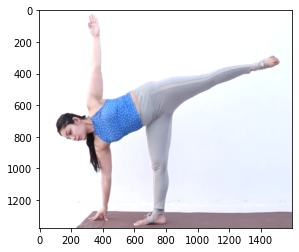

In [ ]:
import matplotlib.pyplot as plt 

image = np.asarray(Image.open("/content/data/ad/2/7.png"))
plt.imshow(image)
plt.show()

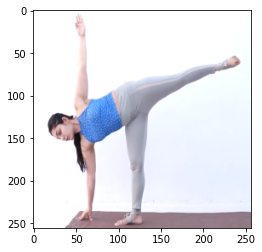

In [ ]:
#step 1 resize (observe the change in x and y axis length compared to previous plot)
image = cv2.resize(np.asarray(image),(256,256),interpolation=cv2.INTER_AREA)
plt.imshow(image)
plt.show()

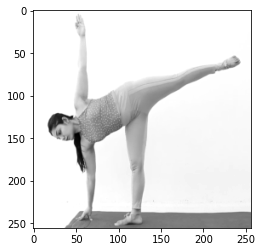

In [ ]:
#step 2 converting to gray scale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap="gray")
plt.show()

In [ ]:
print(image.shape)

(256, 256)


In [ ]:
#we can see that the shape of image is 256,256 but there is no information about channel
#so expand the last dimension by one
image = np.expand_dims(image,axis=-1)
print(image.shape)

(256, 256, 1)


**Exploratory analysis:**

These seven step together constitute one pose


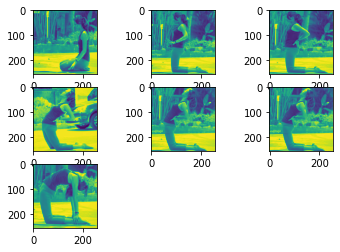

In [ ]:
#if we visualize a sequence
print("These seven step together constitute one pose")

for i,image in enumerate(x[0]):
  plt.subplot(3,3,i+1)
  plt.imshow(np.squeeze(image)) #imshow function does not accept 256,256,1 so squeeze it to 256,256

plt.show()


The above 7 image are considered as single input

In [ ]:
#one hot encoding labels
y = to_categorical(y)

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Train test split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(5, 7, 256, 256, 1) (2, 7, 256, 256, 1) (5, 2) (2, 2)


In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(128, (3, 3), strides=(2,2),activation='relu'),input_shape=(7, 256, 256, 1)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=(2,2),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2,2),activation='relu')))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(256,return_sequences=False))

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 7, 127, 127, 128)  1280     
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 7, 63, 63, 128)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 7, 31, 31, 64)    73792     
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 7, 15, 15, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 7, 7, 7, 32)     

In [ ]:
history = model.fit(x_train,y_train ,epochs = 20 ,verbose=1,validation_data=(x_test,y_test))

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.5722 - accuracy: 0.6000 - val_loss: 0.6769 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 0.5539 - accuracy: 0.8000 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 0.6095 - accuracy: 0.6000 - val_loss: 0.6722 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 0.5687 - accuracy: 0.6000 - val_loss: 0.7198 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.5816 - accuracy: 0.6000 - val_loss: 0.7152 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.5930 - accuracy: 0.6000 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.5689 - accuracy: 0.6000 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=========================

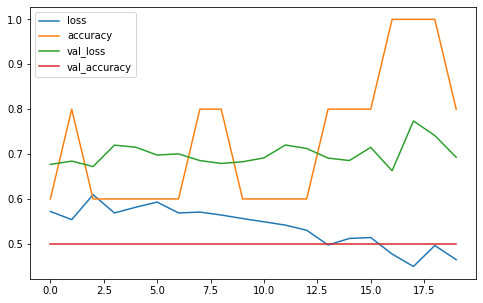

In [ ]:
#plotting accuaracy,val_accuracy,loss and val_loss 
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
to_predict = x_test[0]
actual = y_test[0]
actual_cat = np.argmax(actual[0])
prediction = model.predict(np.expand_dims(to_predict,axis=0))
cat = np.argmax(prediction[0])
print("predicted=",cats[cat],"\n","actual=",cats[actual_cat])

predicted= half_moon 
 actual= half_moon


**Feature extraction process**

In [ ]:
img_tensor = np.expand_dims(x_test[0],axis=0)#to add batch size to the input

layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

In [ ]:
len(activations) #number of layers

6

In [ ]:
type(activations[0])

numpy.ndarray

(batch size,7 time steps,height of feature map,width of feature map,number of feature maps)


In [ ]:
activations[0].shape #batch size,7 time steps,height of feature map,width of feature map,number of feature maps

(1, 7, 127, 127, 128)

if we were to plot all the feature maps from first layer then it would be 7*128 images i.e. 896 images which is not practical.
other layers count of feature maps:-


1.   2nd layer 7*128
2.   3rd layer 7*64
3.   4th layer 7*64
4.   5th layer 7*32